Phase 1 (Data Preparation)

In [1]:
from google.colab import files
from zipfile import ZipFile

# Upload your local zip (the "archive.zip" you showed which has lfw-deepfunneled inside)
uploaded = files.upload()

# Unzip
with ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("lfw_data")

print("Extracted!")


Saving archive.zip to archive.zip
Extracted!


In [2]:
from zipfile import ZipFile

# Unzip your uploaded archive.zip into lfw_data/
with ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("lfw_data")

print("✅ Extracted into lfw_data/")


✅ Extracted into lfw_data/


In [3]:
# Imports for Phase 1
import os
import glob
import cv2                # for image loading & resizing
import numpy as np        # for numerical arrays
import matplotlib.pyplot as plt  # for plotting
base_dir = "lfw_data/lfw-deepfunneled/lfw-deepfunneled"



In [4]:
import os, glob, cv2
import numpy as np

base_dir = "lfw_data/lfw-deepfunneled/lfw-deepfunneled"
IMG_SIZE = (160, 160)
images, labels = [], []

for person in os.listdir(base_dir):
    folder = os.path.join(base_dir, person)
    if os.path.isdir(folder):
        for img_path in glob.glob(os.path.join(folder, "*")):
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype('float32') / 255.0
            images.append(img)
            labels.append(person)

X = np.array(images)
y = np.array(labels)

print("✅ Data loaded")
print("Images shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique identities:", len(np.unique(y)))


✅ Data loaded
Images shape: (13233, 160, 160, 3)
Labels shape: (13233,)
Unique identities: 5749


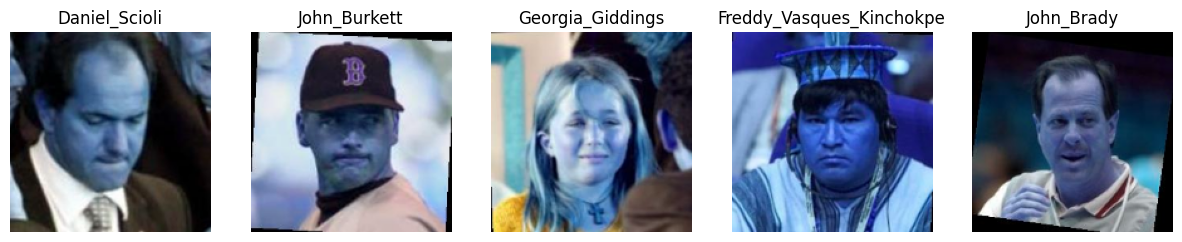

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(15,5))
for i in range(5):
    ax[i].imshow(X[i])
    ax[i].set_title(y[i])
    ax[i].axis("off")
plt.show()


Phase 2 – EDA + Feature Building

In [6]:
!pip install deepface


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00


In [7]:
# Imports for Phase 2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Imports for feature engineering
from deepface import DeepFace
from sklearn.preprocessing import StandardScaler
import numpy as np
import cv2



25-09-23 14:21:44 - Directory /root/.deepface has been created
25-09-23 14:21:44 - Directory /root/.deepface/weights has been created


In [8]:
# Wrap labels into a DataFrame (just like hotel bookings project)
df = pd.DataFrame({"label": y})

# Shape of dataset
print("DataFrame shape:", df.shape)

# Missing values
print("\nMissing values:\n", df.isnull().sum())

# Number of unique persons
print("\nUnique identities:", df['label'].nunique())

# Top 10 identities with the most images
print("\nTop 10 identities with the most images:\n")
print(df['label'].value_counts().head(10))


DataFrame shape: (13233, 1)

Missing values:
 label    0
dtype: int64

Unique identities: 5749

Top 10 identities with the most images:

label
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: count, dtype: int64


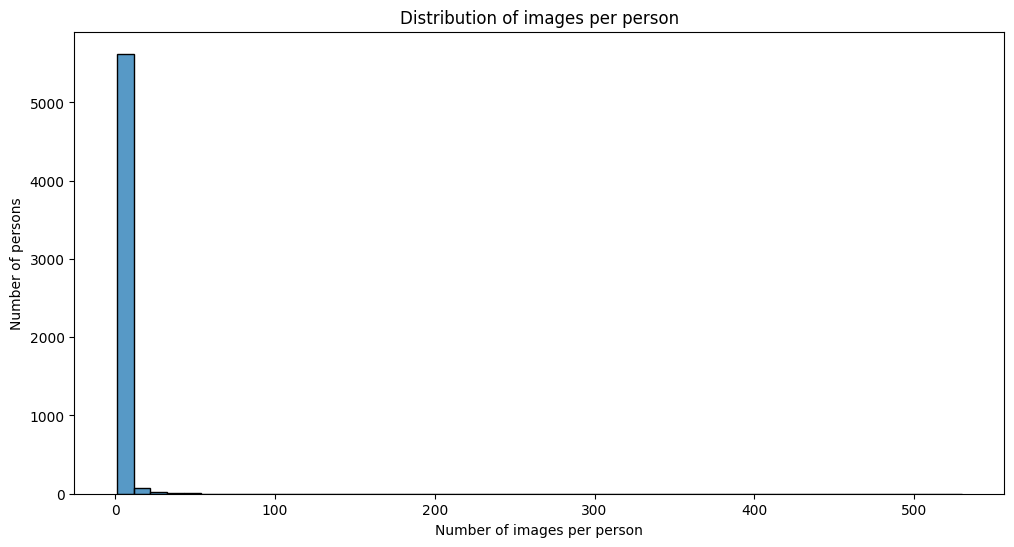

In [9]:
plt.figure(figsize=(12,6))
sns.histplot(df['label'].value_counts(), bins=50)
plt.title("Distribution of images per person")
plt.xlabel("Number of images per person")
plt.ylabel("Number of persons")
plt.show()


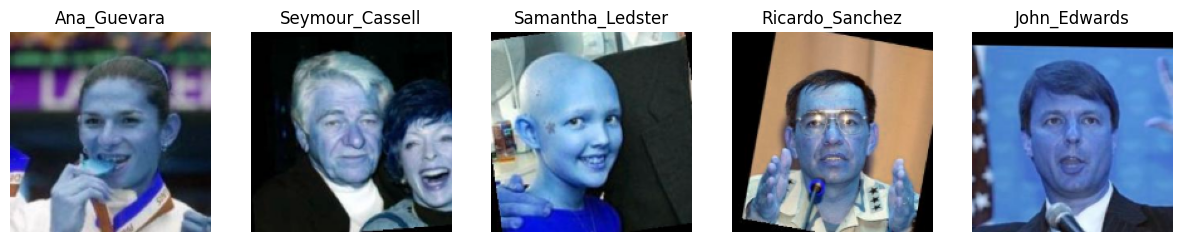

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(15,5))
for i in range(5):
    idx = random.randint(0, len(X)-1)
    ax[i].imshow(X[idx])
    ax[i].set_title(y[idx])
    ax[i].axis("off")
plt.show()


In [11]:
embeddings = []

for img in X:  # X is your original LFW images
    # resize just before embedding
    img_small = cv2.resize(img, (160, 160))
    rep = DeepFace.represent(img_small, model_name="Facenet", enforce_detection=False)
    embeddings.append(rep[0]["embedding"])
    if (i + 1) % 100 == 0:  # print every 100 images
        print(f"{i+1}/{len(X)} images processed")


X_features = np.array(embeddings)
print("✅ Features extracted")
print("Embeddings shape:", X_features.shape)


25-09-23 14:21:49 - 🔗 facenet_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5 to /root/.deepface/weights/facenet_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 271MB/s]


KeyboardInterrupt: 

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Show augmented versions of one image
sample = X[0].reshape((1,160,160,3))

fig, ax = plt.subplots(1,5, figsize=(15,5))
for i, batch in enumerate(datagen.flow(sample, batch_size=1)):
    ax[i].imshow(batch[0])
    ax[i].axis("off")
    if i == 4:  # show 5 examples then stop
        break
plt.show()
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

